# We're going to put a prior on linewidth

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import theano.tensor as tt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u
import seaborn as sns
import mystyle as ms

import corner
import pystan
import pandas as pd
import pickle
import glob
from astropy.io import ascii
import os

import pymc3 as pm
import arviz
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Build the model

In [2]:
class model():
    def __init__(self, f, n0_, n1_, n2_, deltanu_):
        self.f = f
        self.n0 = n0_
        self.n1 = n1_
        self.n2 = n2_
        self.npts = len(f)
        self.M = [len(n0_), len(n1_), len(n2_)]
        self.deltanu = deltanu_
        
    def epsilon(self, i):
        eps = tt.zeros((3,3))
        eps0 = tt.set_subtensor(eps[0][0], 1.)
        eps1 = tt.set_subtensor(eps[1][0], tt.sqr(tt.cos(i)))
        eps1 = tt.set_subtensor(eps1[1], 0.5 * tt.sqr(tt.sin(i)))
        eps2 = tt.set_subtensor(eps[2][0], 0.25 * tt.sqr((3. * tt.sqr(tt.cos(i)) - 1.)))
        eps2 = tt.set_subtensor(eps2[1], (3./8.) * tt.sqr(tt.sin(2*i)))
        eps2 = tt.set_subtensor(eps2[2], (3./8.) * tt.sin(i)**4)

        eps = tt.set_subtensor(eps[0], eps0)
        eps = tt.set_subtensor(eps[1], eps1)
        eps = tt.set_subtensor(eps[2], eps2)
        
        return eps
            
    def lor(self, freq, h, w):
        return h / (1.0 + 4.0/tt.sqr(w)*tt.sqr((self.f - freq)))
    
    def mode(self, l, freqs, hs, ws, eps, split=0):
        for idx in range(self.M[l]):
            for m in range(-l, l+1, 1):
                self.modes += self.lor(freqs[idx] + (m*split), 
                                     hs[idx] * eps[l,abs(m)], 
                                     ws[idx])
  
    def model(self, p, theano=True):
        f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b = p
               
        # Calculate the modes
        eps = self.epsilon(i)        
        self.modes = np.zeros(self.npts)
        self.mode(0, f0, h0, g0, eps)
        self.mode(1, f1, h1, g1, eps, split)
        self.mode(2, f2, h2, g2, eps, split)
               
        #Create the model
        self.mod = self.modes + b
        if theano:
            return self.mod
        else:
            return self.mod.eval()

    # Small separations are fractional
    def asymptotic(self, n, numax, alpha, epsilon, d=0.): 
        nmax = (numax / self.deltanu) - epsilon
        curve = (alpha/2.)*(n-nmax)*(n-nmax)
        return (n + epsilon + d + curve) * self.deltanu

    def f0(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n0, numax, alpha, epsilon, 0.)
    
    def f1(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n1, numax, alpha, epsilon, d01)
    
    def f2(self, p):
        numax, alpha, epsilon, d01, d02 = p
        
        return self.asymptotic(self.n2+1, numax, alpha, epsilon, -d02)

    def gaussian(self, freq, numax, w, A):
        return A * tt.exp(-0.5 * tt.sqr((freq - numax)) / tt.sqr(w))

    def A0(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)
        if theano:
            return height
        else:
            return height.eval()
    
    def A1(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V1        
        if theano:
            return height
        else:
            return height.eval()
    
    def A2(self, f, p, theano=True):
        numax, w, A, V1, V2 = p
        height = self.gaussian(f, numax, w, A)*V2      
        if theano:
            return height
        else:
            return height.eval()

Build the range

In [3]:
nmodes = 10
nbase = 10
n0_ = np.arange(nmodes)+nbase
n1_ = np.copy(n0_)
n2_ = np.copy(n0_) - 1.
fs = .1
nyq = (0.5 * (1./58.6) * u.hertz).to(u.microhertz).value
ff = np.arange(fs, nyq, fs)

Build the frequencies

In [4]:
deltanu_  =  60.
numax_= 1150.
alpha_ = 0.01
epsilon_ = 1.1
d01_ = deltanu_/2. / deltanu_
d02_ = 6. / deltanu_

In [5]:
mod = model(ff, n0_, n1_, n2_, deltanu_)

In [6]:
init_f = [numax_, alpha_, epsilon_, d01_, d02_]

f0_true = mod.f0(init_f)
f1_true = mod.f1(init_f)
f2_true = mod.f2(init_f)

sigma0_ = 1.5
sigma1_ = 2.0
sigma2_ = .5
f0_ = mod.f0(init_f) + np.random.randn(len(f0_true)) * sigma0_
f1_ = mod.f1(init_f) + np.random.randn(len(f1_true)) * sigma1_
f2_ = mod.f2(init_f) + np.random.randn(len(f2_true)) * sigma2_

In [7]:
lo = f2_.min() - .25*deltanu_
hi = f1_.max() + .25*deltanu_

sel = (ff > lo) & (ff < hi)
f = ff[sel]

Reset model for new frequency range

In [8]:
mod = model(f, n0_, n1_, n2_, deltanu_)

Build the linewidths

In [9]:
def kernel(n, rho, L):
    return rho**2 * np.exp(-0.5 * np.subtract.outer(n,n)**2 / L**2)

In [10]:
m_ = .5
c_ = .5
rho_ = 0.1
L_ = 0.3

fs = np.concatenate((f0_, f1_, f2_))
fs -= fs.min()
nf = fs/fs.max()
mu_ = m_ * nf + c_

Sigma_ = kernel(nf, rho_, L_)

lng0_ = np.random.multivariate_normal(mu_, Sigma_)
widths = [np.exp(lng0_)[0:len(f0_)],
          np.exp(lng0_)[len(f0_):len(f0_)+len(f1_)],
          np.exp(lng0_)[len(f0_)+len(f1_):]]

nf_ = nf[:,None]

Build the mode amplitudes

In [11]:
w_ = (0.25 * numax_)/2.355
V1_ = 1.2
V2_ = 0.7
A_ = 10.
init_h =[numax_,   #numax
         w_,       #envelope width
         A_,       #envelope amplitude
         V1_,      #dipole visibility
         V2_       #ocotopole visibility
        ]
sigmaA_ = .2
amps = [mod.A0(f0_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_,
        mod.A1(f1_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_,
        mod.A2(f2_, init_h, theano=False) + np.random.randn(len(f0_)) * sigmaA_]

In [12]:
split_ = 1.
incl_ = np.pi/4.
init_m =[f0_,                         # l0 modes
       f1_,                         # l1 modes
       f2_,                         # l2 modes
       widths[0],             # l0 widths
       widths[1],             # l1 widths
       widths[2],             # l2 widths
       amps[0]**2 * 2.0 / np.pi / widths[0] ,# l0 heights
       amps[1]**2 * 2.0 / np.pi / widths[1] ,# l1 heights
       amps[2]**2 * 2.0 / np.pi / widths[2] ,# l2 heights
       split_,       # splitting
       incl_,                    # inclination angle
       1.                           # background parameters
        ]
p = mod.model(init_m, theano=False)*np.random.chisquare(2., size=len(f))/2

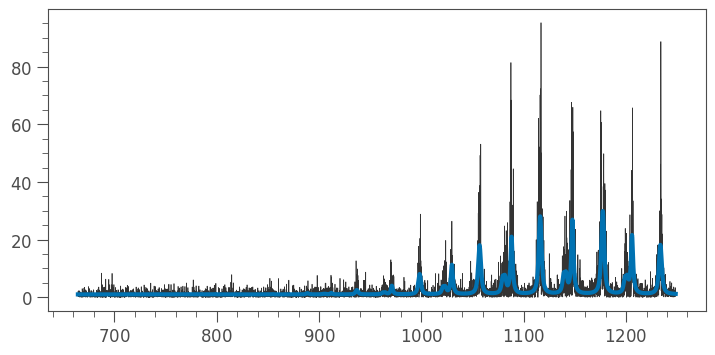

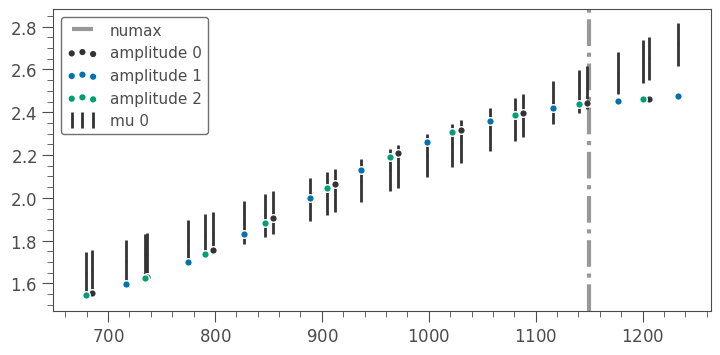

In [13]:
with plt.style.context(ms.ms):
    plt.plot(f, p)
    plt.plot(f, mod.model(init_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    ax.errorbar(np.concatenate([f0_,f1_,f2_]), np.exp(mu_), fmt='|', yerr=rho_,label='mu 0', lw=2, zorder=0)

    ax.scatter(f0_, widths[0], label='amplitude 0', ec='w', s=30)
    ax.scatter(f1_, widths[1], label='amplitude 1', ec='w', s=30)
    ax.scatter(f2_, widths[2], label='amplitude 2', ec='w', s=30)
    
    
    ax.axvline(numax_, lw=3, ls='-.', label='numax', alpha=.5)
    ax.legend()
    plt.show()    

## First lets fit the mode widths...

In [14]:
pm_model = pm.Model()

with pm_model:   
    m = pm.Normal('m', m_, .1) 
    c = pm.Normal('c', c_, .1)
    rho = pm.Normal('rho', rho_, 0.01) 
    ls = pm.Normal('ls', 0.3, 0.01)
    
    mu = pm.gp.mean.Linear(coeffs=m, intercept=c)
    cov = tt.sqr(rho) * pm.gp.cov.ExpQuad(1, ls=ls)     

    gp = pm.gp.Latent(cov_func = cov, mean_func=mu)    
    lng = gp.prior('lng', X=nf_)

    g0 = pm.Deterministic('g0', tt.exp(lng)[0:len(f0_)])
    g1 = pm.Deterministic('g1', tt.exp(lng)[len(f0_):len(f0_)+len(f1_)])
    g2 = pm.Deterministic('g2', tt.exp(lng)[len(f0_)+len(f1_):])   
    
    pm.Normal('like0', g0, .1, observed=widths[0])
    pm.Normal('like1', g1, .1, observed=widths[1])
    pm.Normal('like2', g2, .1, observed=widths[2])    
    
    trace = pm.sample(1000, tune=2000,chains=4, target_accept=.99)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [lng_rotated_, ls, rho, c, m]
Sampling 4 chains: 100%|██████████| 12000/12000 [03:47<00:00, 52.82draws/s]


In [15]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
m,0.477100,0.077385,0.000996,0.325898,0.623610,5872.833456,0.999756
c,0.473535,0.064000,0.000912,0.352224,0.602318,4524.862097,0.999754
rho,0.098109,0.009844,0.000111,0.078982,0.117493,7274.773271,0.999604
ls,0.300790,0.010231,0.000113,0.280685,0.320445,8431.569700,0.999632
lng_rotated___0,-0.402136,0.658234,0.009726,-1.652183,0.918998,4379.097758,1.000314
lng_rotated___1,0.211438,0.593233,0.007480,-0.947704,1.339400,6548.107228,0.999946
lng_rotated___2,0.635412,0.738497,0.009736,-0.718098,2.202713,5634.591503,1.000017
lng_rotated___3,0.468905,0.798824,0.011669,-1.029087,2.095909,5299.563887,1.000042
lng_rotated___4,0.167071,0.844093,0.010321,-1.439039,1.831117,6830.788393,0.999633
lng_rotated___5,-0.120055,0.880170,0.010650,-1.788686,1.678042,6715.857614,0.999594


In [16]:
from pymc3.gp.util import plot_gp_dist

nflin = np.linspace(nf.min(), nf.max(), 100)
fslin = np.linspace(fs.min(), fs.max(), 100)+f2_.min()
mulin = nflin * np.median(trace['m']) + np.median(trace['c'])

with pm_model:
    f_pred = gp.conditional("f_pred", nflin[:,None])
    expf_pred = pm.Deterministic('expf_pred', tt.exp(f_pred))
    pred_samples = pm.sample_posterior_predictive(trace, vars=[expf_pred], samples=1000)

100%|██████████| 1000/1000 [00:08<00:00, 113.01it/s]


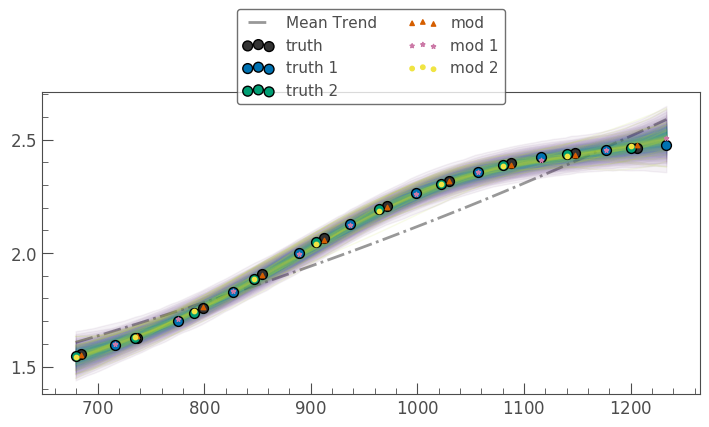

In [17]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    plot_gp_dist(ax, pred_samples['expf_pred'], fslin, palette='viridis', fill_alpha=.05)

    ax.plot(fslin, np.exp(mulin), label='Mean Trend', lw=2, ls='-.', alpha=.5, zorder=0)

    ax.scatter(f0_, widths[0], label='truth', ec='k',s=50,zorder=5)
    ax.scatter(f1_, widths[1], label='truth 1', ec='k',s=50,zorder=5)
    ax.scatter(f2_, widths[2], label='truth 2', ec='k',s=50,zorder=5) 
    
    ax.scatter(f0_, np.median(trace['g0'],axis=0), marker='^', label='mod', s=10,zorder=5)
    ax.scatter(f1_, np.median(trace['g1'],axis=0), marker='*', label='mod 1', s=10,zorder=5)
    ax.scatter(f2_, np.median(trace['g2'],axis=0), marker='o', label='mod 2', s=10,zorder=5)        
     
    
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.3))    

In [18]:
labels=['m','c','rho','ls','g0','g1','g2']

# Now lets try and fit this

In [19]:
pm_model = pm.Model()

BNormal = pm.Bound(pm.Normal, lower=0.)

with pm_model:   
    # Mode locations
    numax = pm.Normal('numax', numax_, 1., testval=numax_)
#     deltanu = pm.Normal('deltanu', deltanu_, 1., testval=deltanu_)
    alpha = pm.Normal('alpha', alpha_, 0.001, testval=alpha_)
    epsilon = pm.Normal('epsilon', epsilon_, 1., testval=epsilon_)
    d01     = pm.Normal('d01', d01_, 0.01, testval=d01_)   
    d02     = pm.Normal('d02', d02_, 0.01, testval=d02_)
    
    sigma0 = pm.HalfCauchy('sigma0', 2., testval=1.5)
    sigma1 = pm.HalfCauchy('sigma1', 2., testval=2.)
    sigma2 = pm.HalfCauchy('sigma2', 2., testval=.5)
    
    f0 = pm.Normal('f0', mod.f0([numax, deltanu_, alpha, epsilon, d01, d02]), sigma0, shape=len(f0_))
    f1 = pm.Normal('f1', mod.f1([numax, deltanu_, alpha, epsilon, d01, d02]), sigma1, shape=len(f1_))
    f2 = pm.Normal('f2', mod.f2([numax, deltanu_, alpha, epsilon, d01, d02]), sigma2, shape=len(f2_))

    # Mode Linewidths
    m = pm.Normal('m', m_, .1) 
    c = pm.Normal('c', c_, .1)
    rho = pm.Normal('rho', rho_, 0.01) 
    ls = pm.Normal('ls', 0.3, 0.01)
    
    mu = pm.gp.mean.Linear(coeffs=m, intercept=c)
    cov = tt.sqr(rho) * pm.gp.cov.ExpQuad(1, ls=ls)     

    gp = pm.gp.Latent(cov_func = cov, mean_func=mu)    
    lng = gp.prior('lng', X=nf_)

    g0 = pm.Deterministic('g0', tt.exp(lng)[0:len(f0_)])
    g1 = pm.Deterministic('g1', tt.exp(lng)[len(f0_):len(f0_)+len(f1_)])
    g2 = pm.Deterministic('g2', tt.exp(lng)[len(f0_)+len(f1_):])          

    # Mode Amplitude & Height
    w = pm.Normal('w', w_, 1., testval=w_)
    A = pm.Normal('A', A_, 1., testval=A_)
    V1 = pm.Normal('V1', V1_, 0.1, testval=V1_)
    V2 = pm.Normal('V2', V2_, 0.1, testval=V2_)
    
    sigmaA = pm.HalfCauchy('sigmaA', 1., testval=0.2)
    Da0 = pm.Normal('Da0',0, 1, shape=len(f0_))
    Da1 = pm.Normal('Da1',0, 1, shape=len(f0_))
    Da2 = pm.Normal('Da2',0, 1, shape=len(f0_))
                    
    a0 = pm.Deterministic('a0', sigmaA * Da0 + mod.A0(f0_, [numax, w, A, V1, V2])) 
    a1 = pm.Deterministic('a1', sigmaA * Da1 + mod.A1(f1_, [numax, w, A, V1, V2])) 
    a2 = pm.Deterministic('a2', sigmaA * Da2 + mod.A2(f2_, [numax, w, A, V1, V2]))   
    
    h0 = pm.Deterministic('h0', 2*tt.sqr(a0)/np.pi/g0)
    h1 = pm.Deterministic('h1', 2*tt.sqr(a1)/np.pi/g1)
    h2 = pm.Deterministic('h2', 2*tt.sqr(a2)/np.pi/g2)
    
    # Mode splitting & model
    xsplit = pm.HalfNormal('xsplit', sigma=2.0, testval=init_m[9] * np.sin(init_m[10]))
    cosi = pm.Uniform('cosi', 0., 1., testval=np.cos(init_m[10]))
    
    i = pm.Deterministic('i', tt.arccos(cosi))
    split = pm.Deterministic('split', xsplit/tt.sin(i))
    
    b = BNormal('b', mu=1., sigma=.1, testval=1.)
    
    fit = mod.model([f0, f1, f2, g0, g1, g2, h0, h1, h2, split, i, b])
    
    like = pm.Gamma('like', alpha=1., beta=1./fit, observed=p)

In [20]:
with pm_model:
    trace = pm.sample(chains=4, target_accept=.99)

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [b, cosi, xsplit, Da2, Da1, Da0, sigmaA, V2, V1, A, w, lng_rotated_, ls, rho, c, m, D2, D1, D0, sigma2, sigma1, sigma0, d02, d01, epsilon, alpha, numax]
Sampling 4 chains: 100%|██████████| 4000/4000 [5:15:48<00:00,  8.22s/draws]  
ERROR:pymc3:There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


In [21]:
df = pm.backends.tracetab.trace_to_dataframe(trace)
df.to_csv('testchains.csv')

In [22]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
numax,1149.994514,1.035425,0.048166,1.147971e+03,1152.082831,88.213884,1.042603
alpha,0.009876,0.000819,0.000052,8.129464e-03,0.011341,23.268963,1.099113
epsilon,1.098295,0.502404,0.050235,5.722620e-01,1.620853,2.003091,46.979780
d01,0.500928,0.010935,0.000770,4.773075e-01,0.520126,13.119588,1.168522
d02,0.099352,0.010555,0.000498,7.775363e-02,0.119553,388.282900,1.001980
D0__0,0.019222,0.873150,0.043833,-1.718541e+00,1.879997,345.828184,1.014862
D0__1,-0.102558,0.912078,0.043094,-1.735292e+00,1.844749,242.543430,1.014147
D0__2,-0.045719,1.017871,0.048743,-2.271771e+00,1.758971,263.101198,1.019736
D0__3,0.190955,1.122725,0.052510,-2.051811e+00,2.231191,362.912019,1.012062
D0__4,-0.553650,1.079947,0.080827,-2.128649e+00,1.932867,4.775366,1.388703


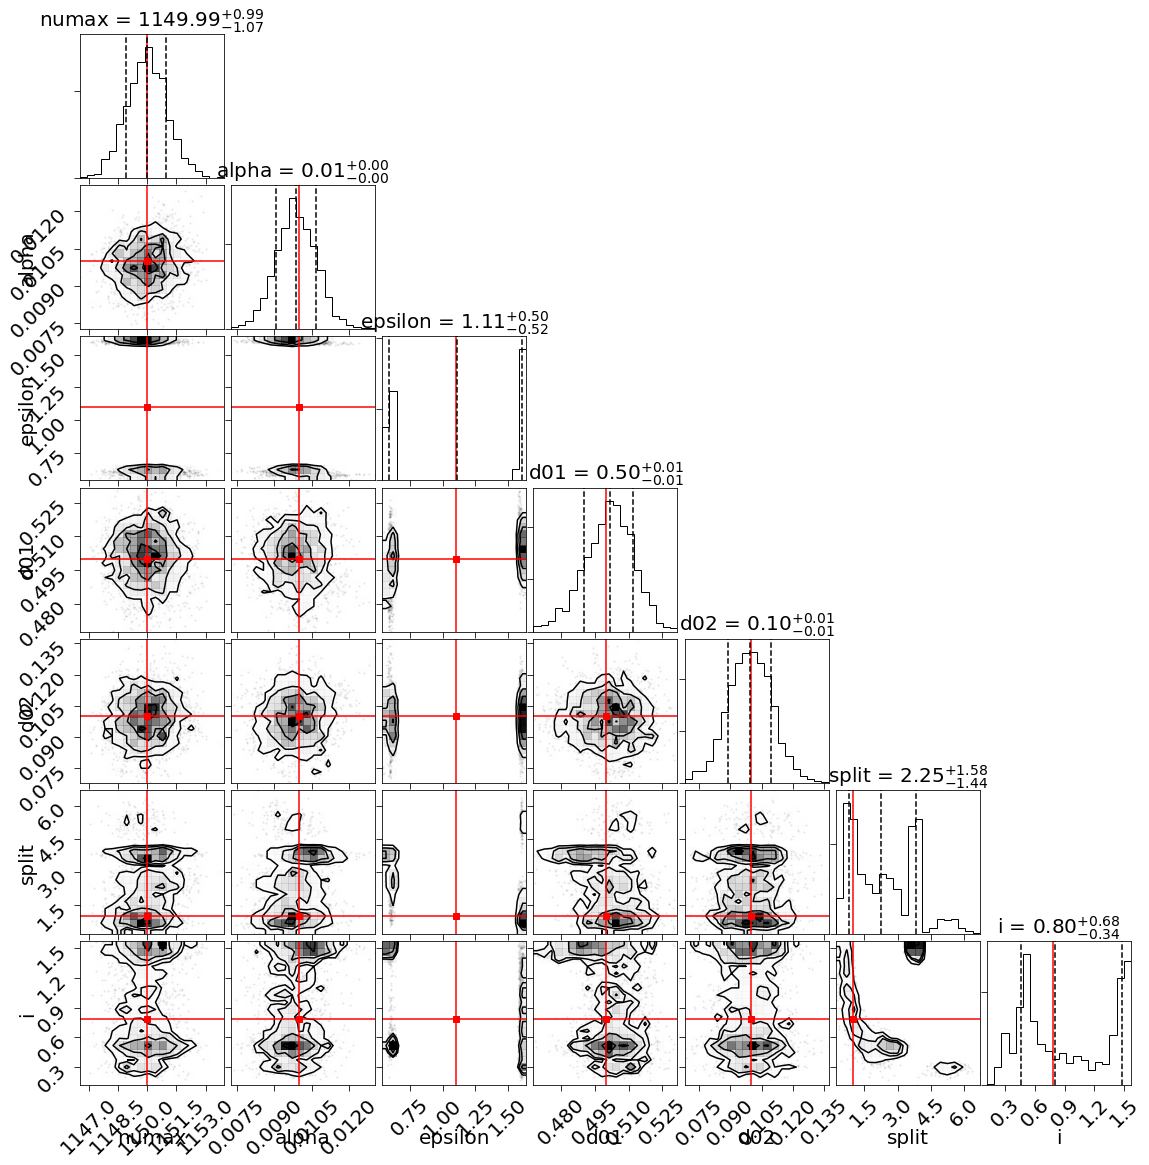

In [23]:
labels = ['numax','alpha','epsilon','d01','d02',
          'split','i']
chain = np.array([trace[label] for label in labels])
truths = [numax_, alpha_, epsilon_, d01_, d02_,
         split_, incl_]
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[.16, .5, .84], truth_color='r',show_titles=True)
plt.show()

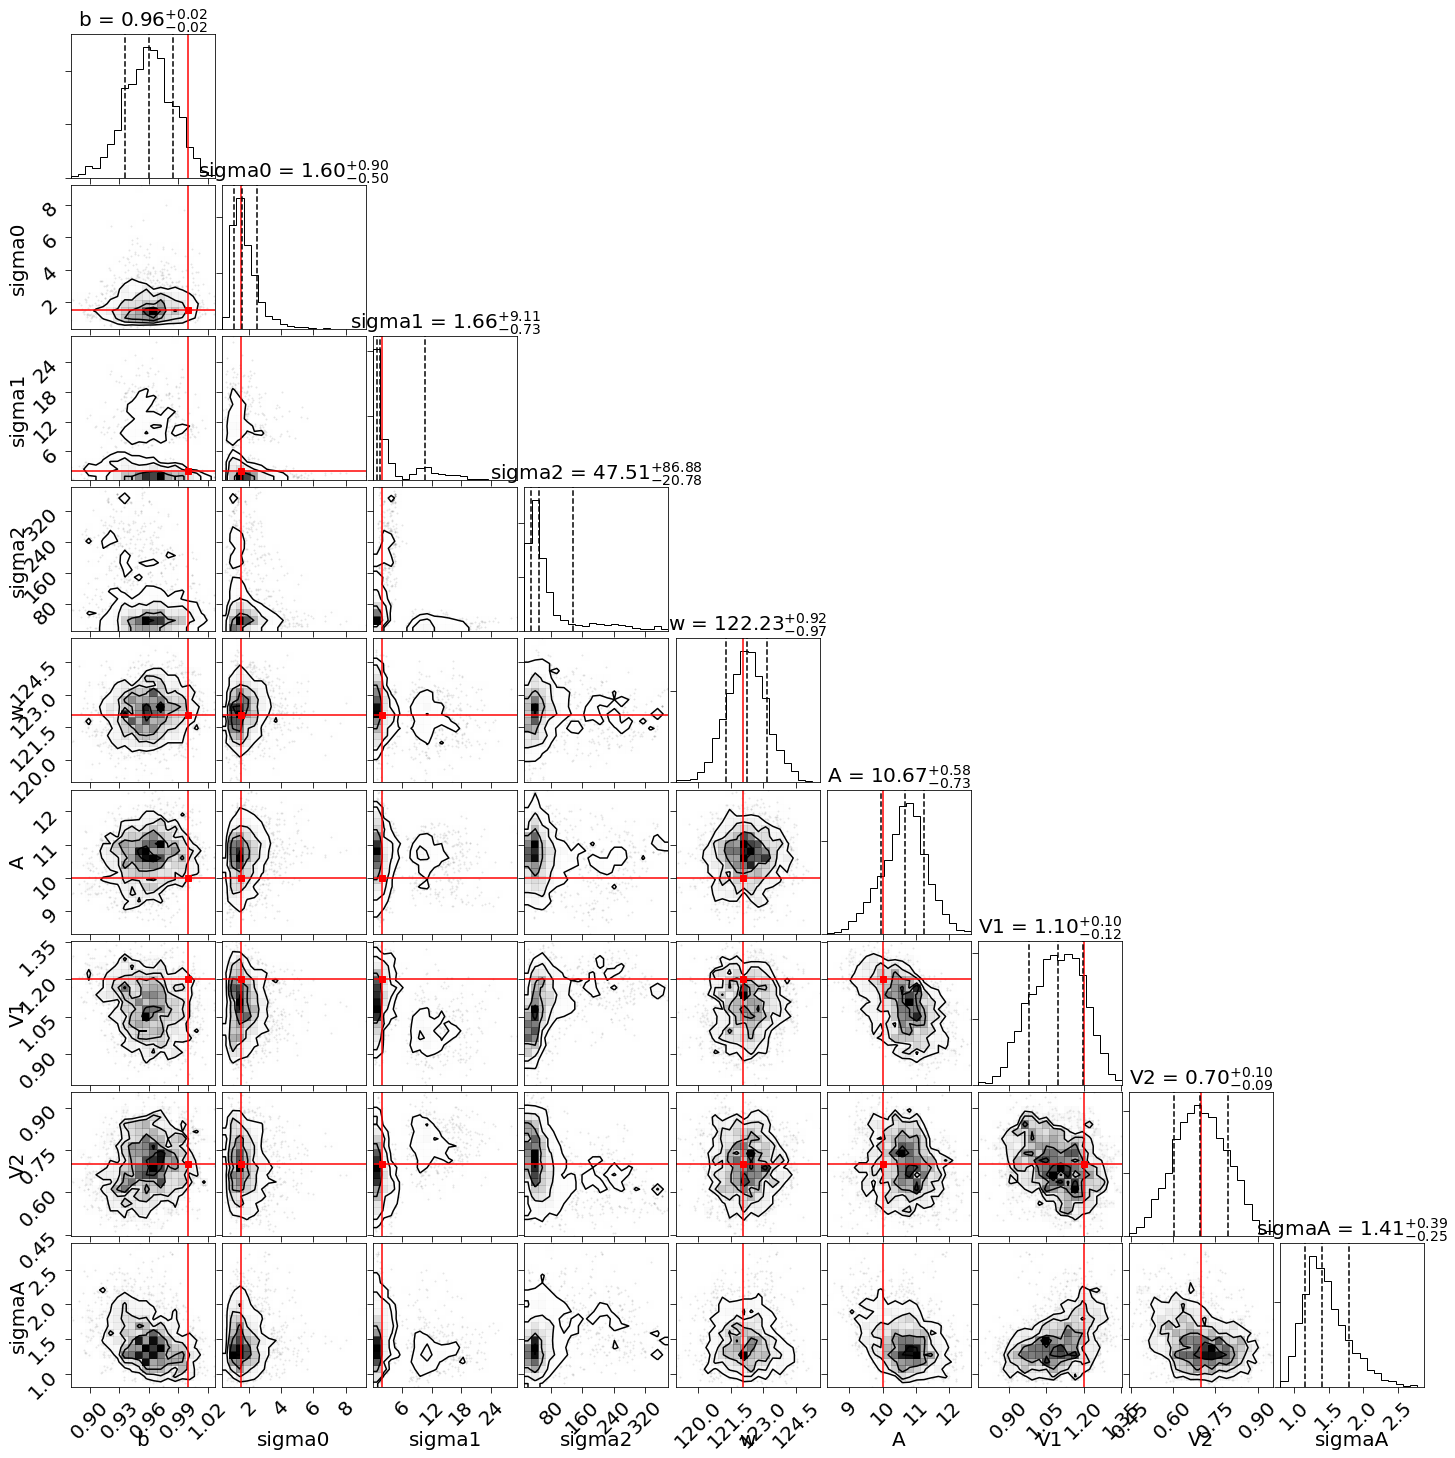

In [24]:
labels = ['b','sigma0','sigma1','sigma2','w','A','V1','V2','sigmaA']
chain = np.array([trace[label] for label in labels])
truths = [1.,sigma0_, sigma1_, sigma2_,w_, A_, V1_, V2_, 0.2]
corner.corner(chain.T, labels=labels, truths=truths, quantiles=[.16, .5, .84], truth_color='r',show_titles=True)
plt.show()

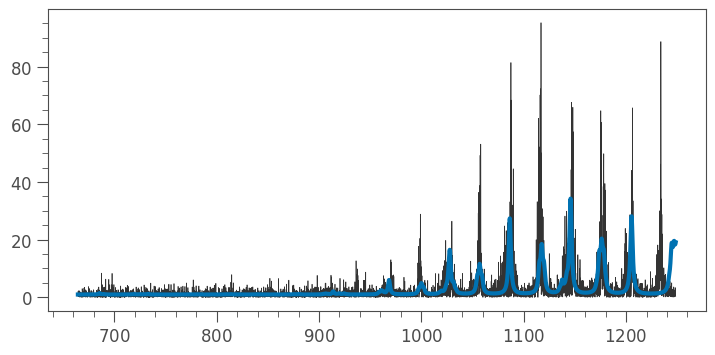

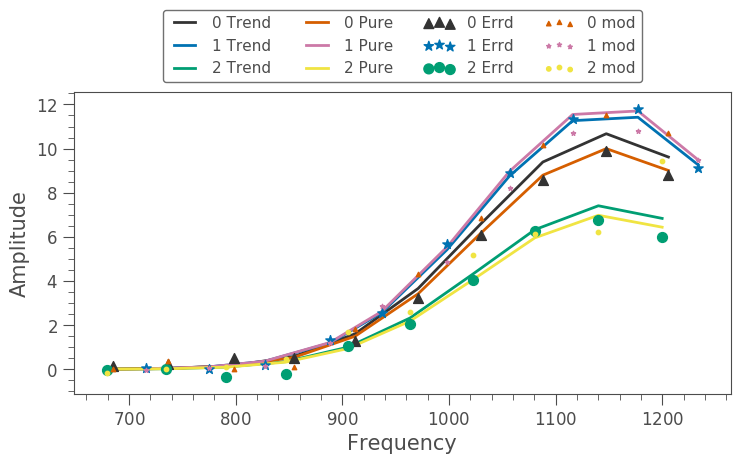

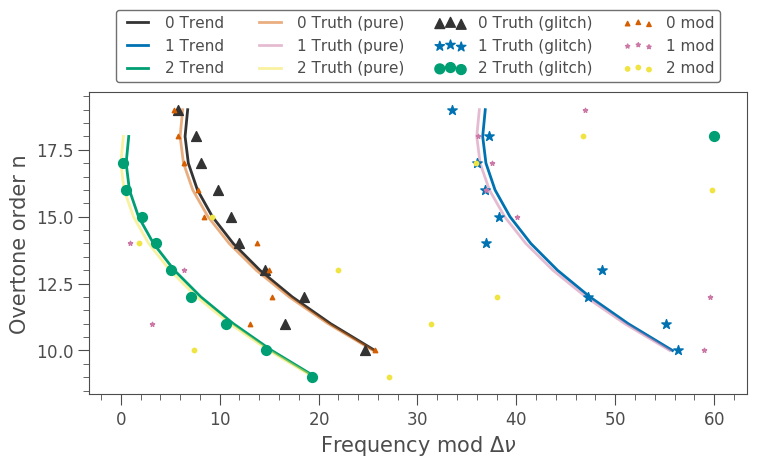

In [33]:
with plt.style.context(ms.ms):
    res_m = [np.median(trace[label], axis=0) for label in ['f0','f1','f2','g0','g1','g2',
                                                         'h0','h1','h2','split','i','b']]
    plt.plot(f, p)
    plt.plot(f, mod.model(res_m, theano=False), lw=3)
    plt.show()
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'w', 'A', 'V1','V2']]
    resls = [np.median(trace[label],axis=0) for label in ['a0','a1','a2']]
       
    ax.plot(f0_, mod.A0(f0_, res,theano=False), label='0 Trend',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, res,theano=False), label='1 Trend',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, res,theano=False), label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_, amps[0], marker='^',label='0 Errd',  s=50, zorder=2)
    ax.scatter(f1_, amps[1], marker='*',label='1 Errd',  s=50, zorder=2)
    ax.scatter(f2_, amps[2], marker='o',label='2 Errd',  s=50, zorder=2)   
  
    ax.plot(f0_, mod.A0(f0_, init_h, theano=False), label='0 Pure',lw=2, zorder=1)
    ax.plot(f1_, mod.A1(f1_, init_h, theano=False), label='1 Pure',lw=2, zorder=1)
    ax.plot(f2_, mod.A2(f2_, init_h, theano=False), label='2 Pure',lw=2, zorder=1)

    ax.scatter(f0_, resls[0], marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(f1_, resls[1], marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(f2_, resls[2], marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))      
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Amplitude')
    
    plt.show()
    
    fig, ax = plt.subplots()
    res = [np.median(trace[label]) for label in ['numax', 'alpha', 'epsilon','d01','d02']]
    resls = [np.median(trace[label],axis=0) for label in ['f0','f1','f2']]
    stdls = [np.std(trace[label],axis=0) for label in ['f0','f1','f2']]
       
    ax.plot(mod.f0(res)%deltanu_, n0_, label='0 Trend',lw=2, zorder=1)
    ax.plot(mod.f1(res)%deltanu_, n1_, label='1 Trend',lw=2, zorder=1)
    ax.plot(mod.f2(res)%deltanu_, n2_, label='2 Trend',lw=2, zorder=1)

    ax.scatter(f0_%deltanu_, n0_, marker='^',label='0 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f1_%deltanu_, n1_, marker='*',label='1 Truth (glitch)',  s=50, zorder=2)
    ax.scatter(f2_%deltanu_, n2_, marker='o',label='2 Truth (glitch)',  s=50, zorder=2)   
    
    ax.plot(f0_true%deltanu_, n0_, alpha=.5, label='0 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f1_true%deltanu_, n1_, alpha=.5, label='1 Truth (pure)',  lw=2, zorder=1)
    ax.plot(f2_true%deltanu_, n2_, alpha=.5, label='2 Truth (pure)',  lw=2, zorder=1)      
    
    ax.scatter(resls[0]%deltanu_, n0_, marker='^',label='0 mod', s=10, zorder=3)
    ax.scatter(resls[1]%deltanu_, n1_, marker='*',label='1 mod', s=10, zorder=3)
    ax.scatter(resls[2]%deltanu_, n2_, marker='o',label='2 mod', s=10, zorder=3)    
    
    ax.set_xlabel(r'Frequency mod $\Delta\nu$')
    ax.set_ylabel('Overtone order n')
    ax.legend(loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.3))    

In [26]:
nflin = np.linspace(nf.min(), nf.max(), 100)
fslin = np.linspace(fs.min(), fs.max(), 100)+f2_.min()
mulin = nflin * np.median(trace['m']) + np.median(trace['c'])

with pm_model:
    f_pred = gp.conditional("f_pred", nflin[:,None])
    expf_pred = pm.Deterministic('expf_pred', tt.exp(f_pred))
    pred_samples = pm.sample_posterior_predictive(trace, vars=[expf_pred], samples=1000)


100%|██████████| 1000/1000 [00:06<00:00, 154.70it/s]


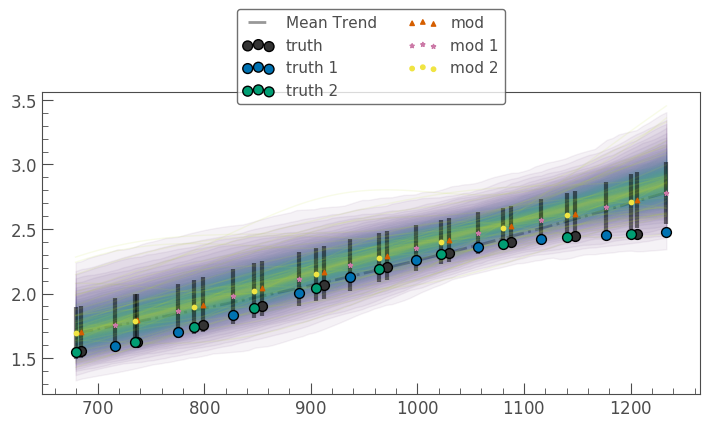

In [27]:
with plt.style.context(lk.MPLSTYLE):
    fig, ax = plt.subplots()
    plot_gp_dist(ax, pred_samples['expf_pred'], fslin, palette='viridis', fill_alpha=.05)

    ax.plot(fslin, np.exp(mulin), label='Mean Trend', lw=2, ls='-.', alpha=.5, zorder=0)

    ax.scatter(f0_, widths[0], label='truth', ec='k',s=50,zorder=5)
    ax.scatter(f1_, widths[1], label='truth 1', ec='k',s=50,zorder=5)
    ax.scatter(f2_, widths[2], label='truth 2', ec='k',s=50,zorder=5) 
    
    ax.scatter(f0_, np.median(trace['g0'],axis=0), marker='^', label='mod', s=10,zorder=5)
    ax.scatter(f1_, np.median(trace['g1'],axis=0), marker='*', label='mod 1', s=10,zorder=5)
    ax.scatter(f2_, np.median(trace['g2'],axis=0), marker='o', label='mod 2', s=10,zorder=5)        
    
    ax.errorbar(f0_, np.median(trace['g0'],axis=0), yerr=np.std(trace['g0'],axis=0), fmt='|', c='k', lw=3, alpha=.5)
    ax.errorbar(f1_, np.median(trace['g1'],axis=0), yerr=np.std(trace['g1'],axis=0), fmt='|', c='k', lw=3, alpha=.5)
    ax.errorbar(f2_, np.median(trace['g2'],axis=0), yerr=np.std(trace['g2'],axis=0), fmt='|', c='k', lw=3, alpha=.5)          
     
    
    ax.legend(loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.3))    

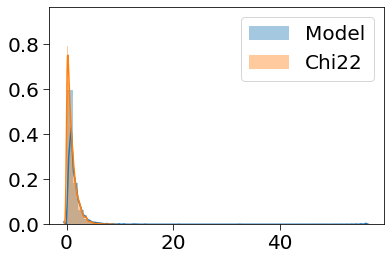

In [28]:
residual = p/mod.model(res_m, theano=False)
sns.distplot(residual, label='Model')
sns.distplot(np.random.chisquare(2, size=10000)/2, label=r'Chi22')
plt.legend()

## Let's investigate any divergences:

In [29]:
def pairplot_divergence(x, y, trace, ax=None, divergence=True, color='C3', divergence_color='C2'):
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(x, y, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(x[divergent], y[divergent], 'o', color=divergence_color)
    return ax

def divergence_corner(trace, labels, entry=0):
    chain = np.array([trace[label] for label in labels])
    if len(chain.shape) > 2:
        chain = chain[:,:,entry]
        print('Only showing the entry [{}] for multi-parameter labels'.format(entry))
        titleadd = '[{}]'.format(entry)
    else:
        titleadd = ''
    
    K = len(chain)
    factor = 2.0           # size of one side of one panel
    lbdim = 0.5 * factor   # size of left/bottom margin
    trdim = 0.2 * factor   # size of top/right margin
    whspace = 0.05         # w/hspace size
    plotdim = factor * K + factor * (K - 1.) * whspace
    dim = lbdim + plotdim + trdim

    # Create a new figure if one wasn't provided.
    fig, axes = plt.subplots(K, K, figsize=(dim, dim))

    lb = lbdim / dim
    tr = (lbdim + plotdim) / dim
    fig.subplots_adjust(left=lb, bottom=lb, right=tr, top=tr,
                        wspace=whspace, hspace=whspace)

    hist_kwargs = dict()
    hist_kwargs["color"] = hist_kwargs.get("color", 'k')
    for i, x in enumerate(chain):
        ax = axes[i,i]
        bins_1d = int(max(1, 20.))
        n, _, _ = ax.hist(x, bins=bins_1d, histtype='step')       


        title = "{}{}".format(labels[i], titleadd)
        ax.set_title(title)    

        for j, y in enumerate(chain):
            ax = axes[i, j]

            if j > i:    
                ax.set_frame_on(False)
                ax.set_xticks([])
                ax.set_yticks([])
                continue
            elif j == i:
                ax.set_xticks([])
                ax.set_yticks([])            
                continue    

            ax = pairplot_divergence(y, x, trace, ax=ax)

            if i < K - 1:
                ax.set_xticklabels([])
            if j > 0:
                ax.set_yticklabels([])   

In [30]:
def biasplot(label, true):                                                      
    logtau = np.log(trace[label])                                               
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]          
    plt.figure(figsize=(15, 4))                                                 
    plt.axhline(np.log(true), lw=2.5, color='gray')                             
    plt.plot(mlogtau, lw=2.5)                                                   
    plt.xlabel('Iteration')                                                     
    plt.ylabel('MCMC mean of log({})'.format(label))                            
    plt.title('MCMC estimation of log({})'.format(label));   

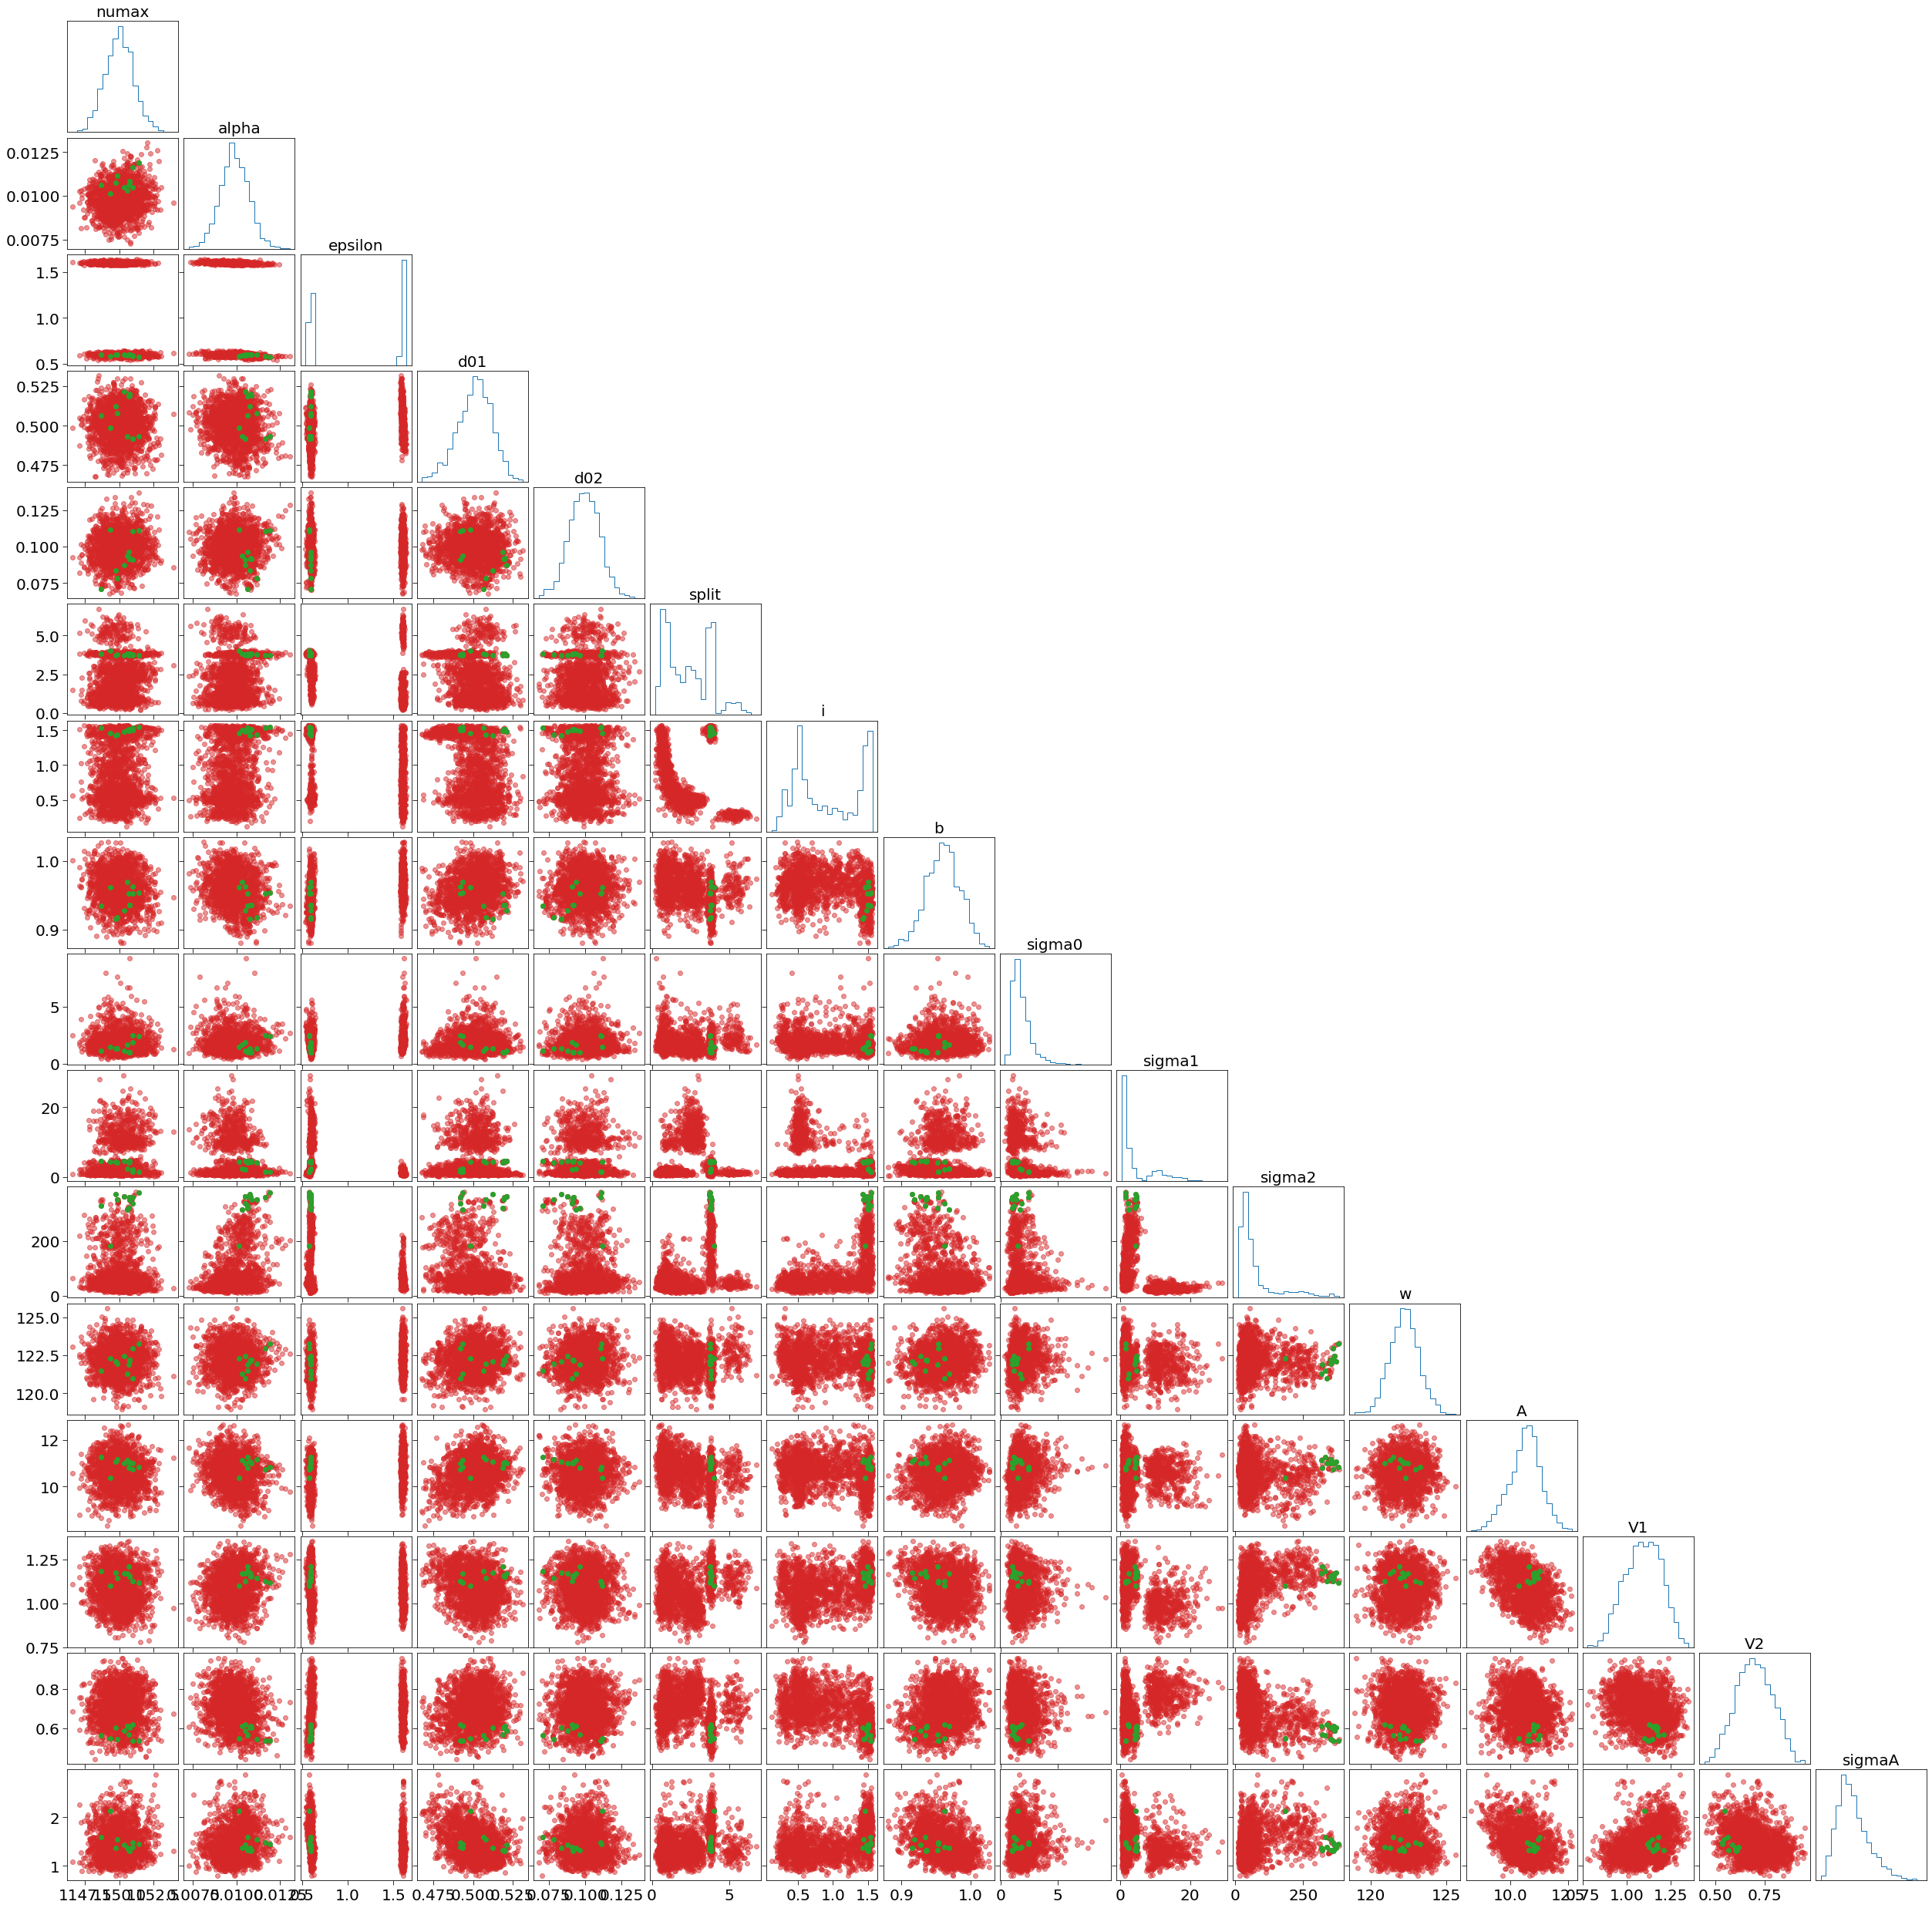

In [31]:
labels = ['numax','alpha','epsilon','d01','d02',
          'split','i','b','sigma0','sigma1','sigma2',
          'w','A','V1','V2','sigmaA']
divergence_corner(trace, labels)

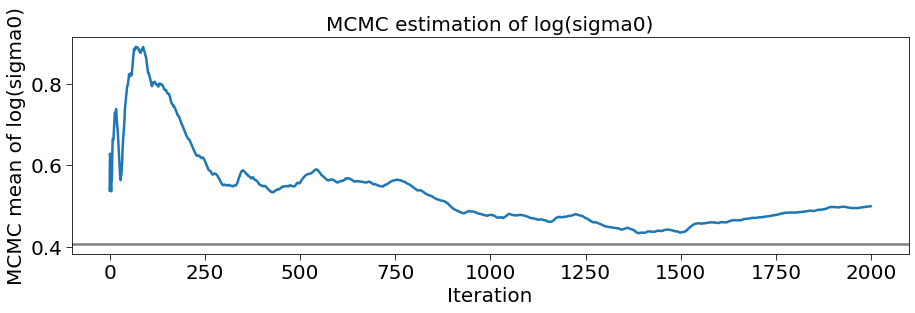

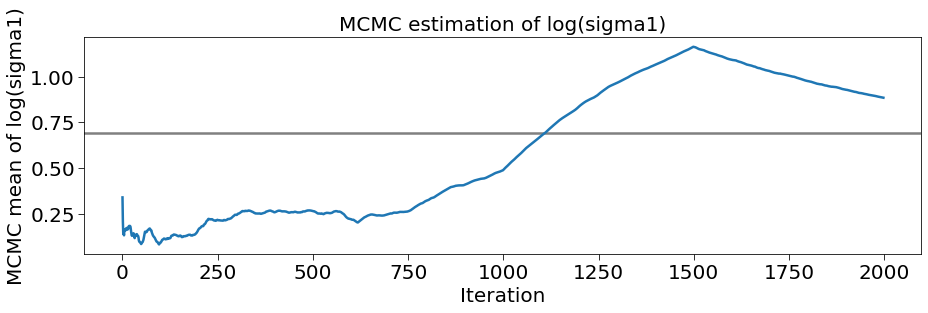

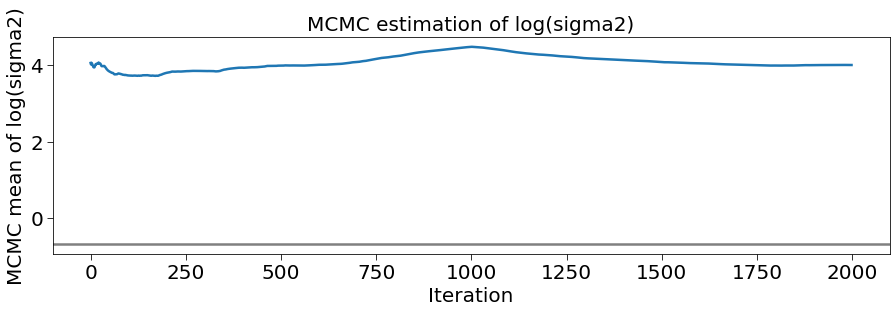

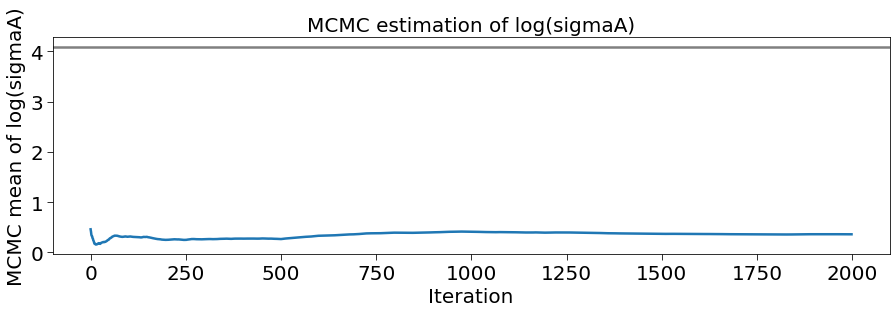

In [32]:
biasplot('sigma0',sigma0_)
biasplot('sigma1',sigma1_)
biasplot('sigma2',sigma2_)
biasplot('sigmaA',deltanu_)